## Default Estimator and WoE Binning

#### Importing Libraries and Setting Up the Environment

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
current_dir = os.getcwd()

# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# ignore warrnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset from the CSV file
df=pd.read_csv('../data/final_df.csv')

In [3]:
df

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,Amount,Value,TransactionStartTime,...,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId1,ChannelId2,ChannelId3,ChannelId5
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,0.092004,0.000101,2018-11-15 02:18:49+00:00,...,0,0,0,0,0,0,0,0,1,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,0.091910,0.000002,2018-11-15 02:19:08+00:00,...,0,0,0,0,0,0,0,1,0,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,0.091958,0.000050,2018-11-15 02:44:21+00:00,...,0,0,0,0,0,0,0,0,1,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,0.093750,0.002206,2018-11-15 03:32:55+00:00,...,0,0,0,0,0,1,0,0,1,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,0.091853,0.000065,2018-11-15 03:34:21+00:00,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,0.091820,0.000101,2019-02-13 09:54:09+00:00,...,0,0,0,0,0,0,0,1,0,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,0.092004,0.000101,2019-02-13 09:54:25+00:00,...,0,0,0,0,0,0,0,0,1,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,0.091910,0.000002,2019-02-13 09:54:35+00:00,...,0,0,0,0,0,0,0,1,0,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,0.092188,0.000303,2019-02-13 10:01:10+00:00,...,0,0,0,0,1,0,0,0,1,0


In [4]:
from scripts.calculate_RFMS_score import RFMSRiskClassifier

### Construct the Default Estimator (Proxy)

- Use RFMS scores to create a boundary between "good" (low-risk) and "bad" (high-risk) customers.
- Visualize customer transactions in the RFMS space to understand where to establish the boundary.
- Based on the RFMS score, assign customers to "good" or "bad" risk categories.

#### Running the Risk Classification Model

In [5]:
from datetime import datetime
# Get the current date dynamically in 'YYYY-MM-DD' format for risk classification
current_date = datetime.now().strftime('%Y-%m-%d')

# Instantiate the RFMSRiskClassifier with the processed DataFrame
rfms_classifier = RFMSRiskClassifier(df)

# # Run the classification process to obtain the classified DataFrame, WOE (Weight of Evidence) results, and IV (Information Value)
# classified_df, woe_results, iv_value = classifier.run(current_date)

In [6]:
rfms_classifier.calculate_recency(current_date)

# Step 2: Calculate Frequency
rfms_classifier.calculate_frequency()

# Step 3: Calculate Monetary
rfms_classifier.calculate_monetary()

# Step 4: Calculate Seasonality
rfms_classifier.calculate_seasonality()

# Step 5: Normalize RFMS scores
rfms_classifier.normalize_rfms()

# Step 6: Assign Risk Categories
classified_df=rfms_classifier.assign_risk_category(threshold=0.25)

#### Displaying the Classified DataFrame

In [7]:
# Filter unique CustomerID and keep the first occurrence of all columns
# Print and display the classified DataFrame after running the RFMSRiskClassifier
print("Classified DataFrame:")
classified_df = classified_df[['CustomerId','Recency','Frequency','Monetary','Seasonality','RFMS_score','Risk_category']]
classified_df

Classified DataFrame:


,CustomerId,Recency,Frequency,Monetary,Seasonality,RFMS_score,Risk_category
0,CustomerId_4406,1.0,0.028851,0.055737,1.000000,0.521147,good
1,CustomerId_4406,1.0,0.028851,0.055737,1.000000,0.521147,good
2,CustomerId_4683,1.0,0.000244,0.000936,0.000000,0.250295,good
3,CustomerId_988,1.0,0.009046,0.017819,1.000000,0.506716,good
4,CustomerId_988,1.0,0.009046,0.017819,1.000000,0.506716,good
...,...,...,...,...,...,...,...
95657,CustomerId_3078,0.0,0.139853,0.274333,0.333333,0.186880,bad
95658,CustomerId_3874,0.0,0.010269,0.020131,0.333333,0.090933,bad
95659,CustomerId_3874,0.0,0.010269,0.020131,0.333333,0.090933,bad
95660,CustomerId_1709,0.0,0.127873,0.247166,1.000000,0.343760,good


In [8]:
classified_df = classified_df.groupby('CustomerId', as_index=False).first()
classified_df

,CustomerId,Recency,Frequency,Monetary,Seasonality,RFMS_score,Risk_category
0,CustomerId_1,0.933333,0.000000,0.000468,0.000000,0.233450,bad
1,CustomerId_10,0.933333,0.000000,0.000468,0.000000,0.233450,bad
2,CustomerId_1001,0.988889,0.000978,0.002340,0.000000,0.248052,bad
3,CustomerId_1002,1.000000,0.002445,0.005147,0.666667,0.418565,good
4,CustomerId_1003,0.133333,0.001222,0.002808,0.000000,0.034341,bad
...,...,...,...,...,...,...,...
3737,CustomerId_992,0.055556,0.001222,0.002808,0.000000,0.014896,bad
3738,CustomerId_993,0.288889,0.000978,0.002340,0.000000,0.073052,bad
3739,CustomerId_994,1.000000,0.024450,0.047502,1.000000,0.517988,good
3740,CustomerId_996,0.755556,0.003912,0.007965,0.000000,0.191858,bad


#### Counting the Risk Categories in the Classified DataFrame

In [9]:
# Display the count of each risk category in the classified DataFrame
classified_df.Risk_category.value_counts()

Risk_category
bad     2711
good    1031
Name: count, dtype: int64

#### Visualizing User Segmentation in RFMS Space

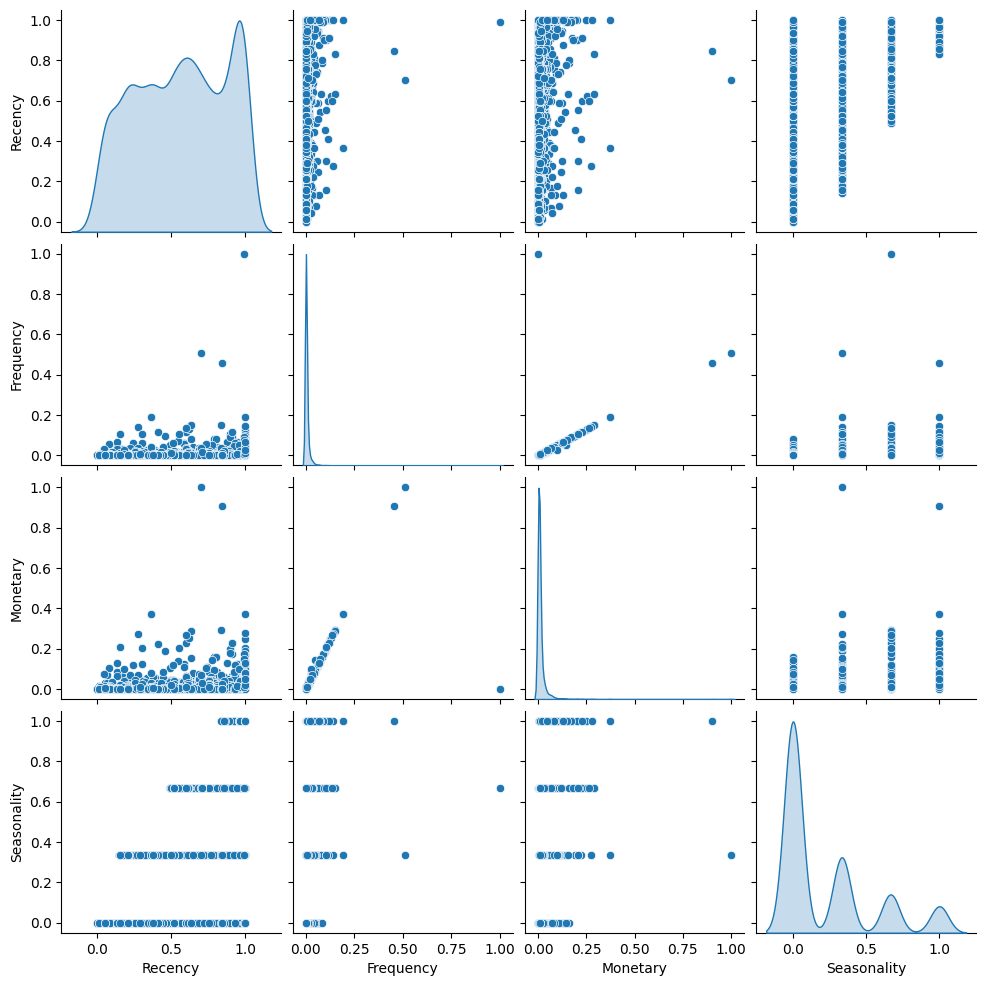

In [10]:
# We have RFMS columns: 'Recency', 'Frequency', 'Monetary', 'Seasonality'
# Create a pairplot to visualize the relationships between these RFMS features in the classified DataFrame
sns.pairplot(classified_df[['Recency', 'Frequency', 'Monetary', 'Seasonality']], diag_kind='kde')

# Display the plot
plt.show()

In [10]:
# Group by CustomerId, keeping the first occurrence of all columns and max of 'FraudResult'
df = df.groupby('CustomerId', as_index=False).agg({
    'Total_Transaction_Amount':'first',
    'Avg_Transaction_Amount':'first',
    'Transaction_Count':'first', 
    'Std_Transaction_Amount':'first',
    'Amount': 'first',
    'Value': 'first',
    'PricingStrategy': 'first',
    'ChannelId1':'first',
    'ChannelId2':'first',
    'ChannelId3':'first',
    'ChannelId5':'first',
    'FraudResult': 'max'  # Keep the maximum value of FraudResult
})

In [11]:
# Merge transactional and RFMS score dataset 
rfms_df =classified_df[['CustomerId','Risk_category']]
merged_df = pd.merge(df, rfms_df, on='CustomerId', how='inner')
merged_df

,CustomerId,Total_Transaction_Amount,Avg_Transaction_Amount,Transaction_Count,Std_Transaction_Amount,Amount,Value,PricingStrategy,ChannelId1,ChannelId2,ChannelId3,ChannelId5,FraudResult,Risk_category
0,CustomerId_1,0.556885,0.045974,1,0.005449,0.090993,0.001012,4,0,1,0,0,0,bad
1,CustomerId_10,0.556885,0.045974,1,0.005449,0.090993,0.001012,4,0,1,0,0,0,bad
2,CustomerId_1001,0.557044,0.047525,5,0.001982,0.092831,0.001012,2,0,0,1,0,0,bad
3,CustomerId_1002,0.556961,0.047124,11,0.000169,0.092050,0.000152,4,0,0,1,0,0,good
4,CustomerId_1003,0.557044,0.047451,6,0.001822,0.092831,0.001012,2,0,0,1,0,0,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,CustomerId_992,0.557044,0.047451,6,0.001839,0.092831,0.001012,2,0,0,1,0,0,bad
3738,CustomerId_993,0.557044,0.047525,5,0.002038,0.092831,0.001012,2,0,0,1,0,0,bad
3739,CustomerId_994,0.559826,0.047678,101,0.004472,0.092004,0.000101,2,0,0,1,0,0,good
3740,CustomerId_996,0.557676,0.047988,17,0.001339,0.092831,0.001012,2,0,0,1,0,0,bad


### Perform Weight of Evidence (WoE) Binning

- Apply WoE binning to better separate customers into risk categories based on their RFMS scores.
- WoE binning helps identify which groups of RFMS scores are more strongly associated with default risk.

In [12]:
# lable encode risk_catagory
import pandas as pd
# or

def labelencoder(self):
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder() 
    self['Risk_category']= label_encoder.fit_transform(self['Risk_category'])
    return self

merged_df=labelencoder(merged_df)

##### Displaying Weight of Evidence (WoE) Results

In [25]:
# Print and display the WoE results obtained from the RFMSRiskClassifier
print("\nWoE Results:")
woe_results

,variable,info_value
0,Amount,0.203724


#### Displaying Information Value (IV)

In [18]:
# Print the Information Value (IV) to assess the predictive power of the features
print(f"\nInformation Value (IV):")
# Step 7: Calculate WoE and IV for a specific feature
# Calculate IV for each relevant transactional column
transactional_columns = merged_df.columns.difference(['Risk_category'])  # Example columns
# Initialize an empty list to store results
results = []

# Loop through each feature and calculate WoE and IV
for feature in transactional_columns:
    info_values = rfms_classifier.calculate_woe_iv(merged_df, feature, 'Risk_category')  # Adjust target as necessary
    
    # Append the result to the results list
    results.append(info_values)

# Concatenate all results into a single DataFrame
final_results = pd.concat(results, ignore_index=True)
# Display the final IV results and make ascending fales
final_results.sort_values(by='IV', ascending=False)


Information Value (IV):


,Feature,IV
11,Transaction_Count,2.219366
10,Total_Transaction_Amount,1.189394
9,Std_Transaction_Amount,1.022223
1,Avg_Transaction_Amount,0.885068
12,Value,0.212386
0,Amount,0.203724
8,PricingStrategy,0.027135
13,binned_feature,0.018514
2,ChannelId1,0.005861
7,FraudResult,0.001995


#### Plotting Weight of Evidence (WoE) Results

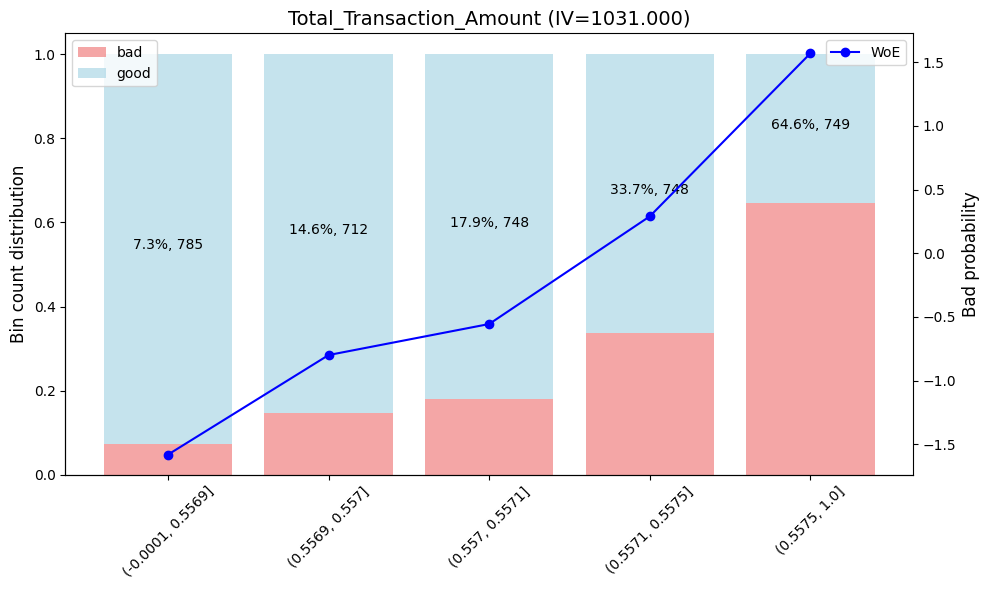

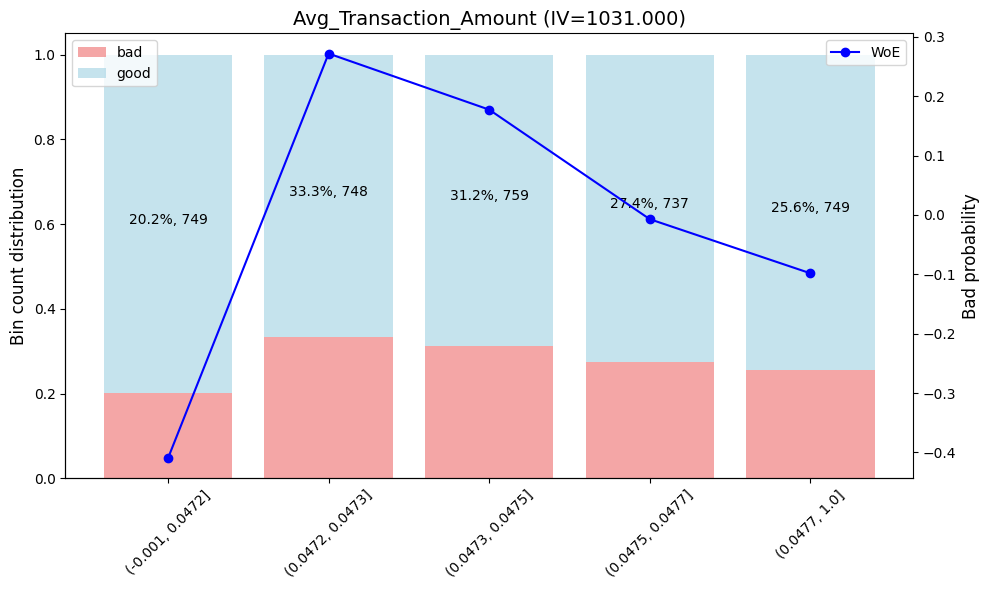

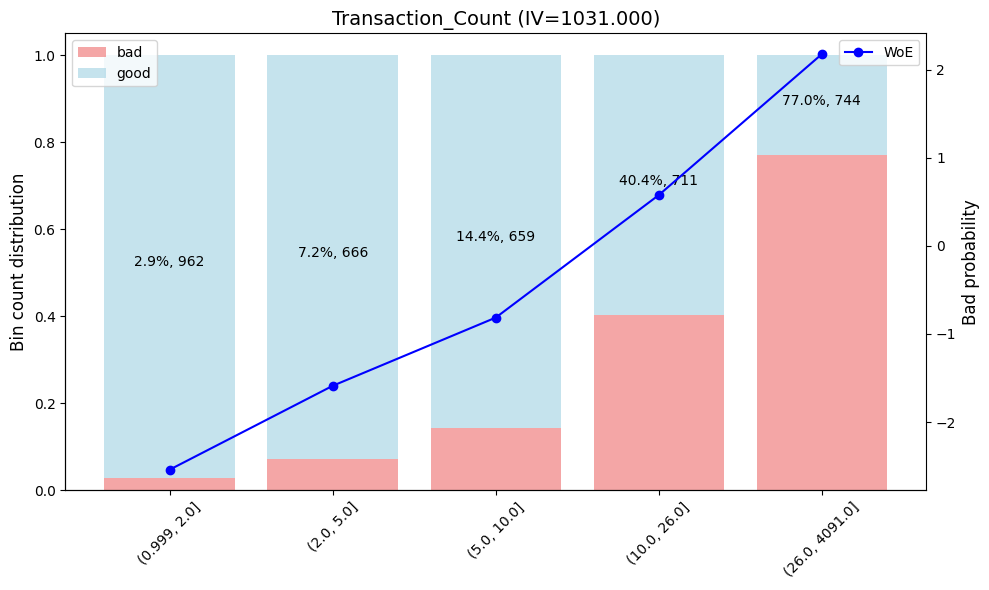

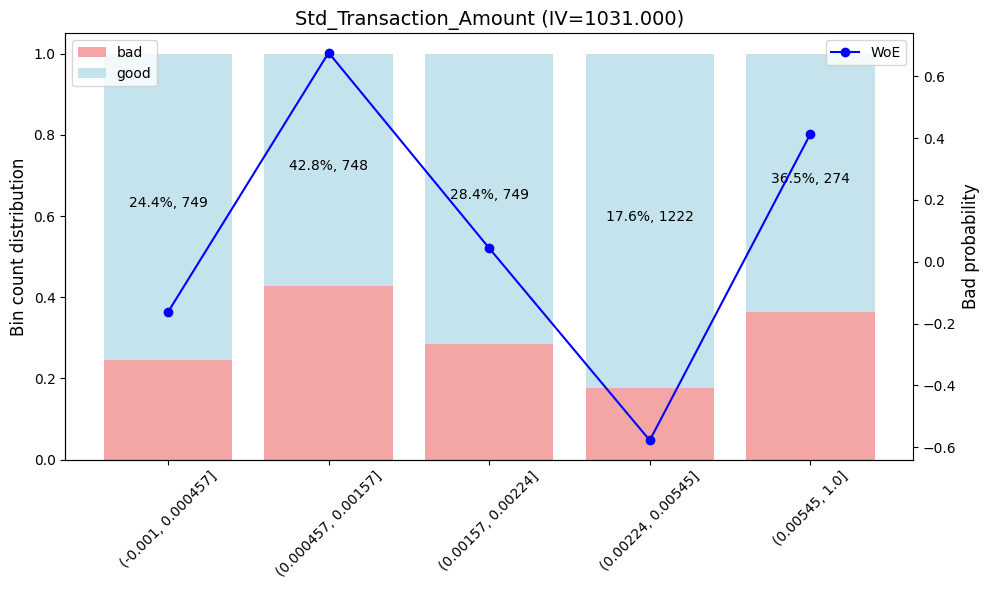

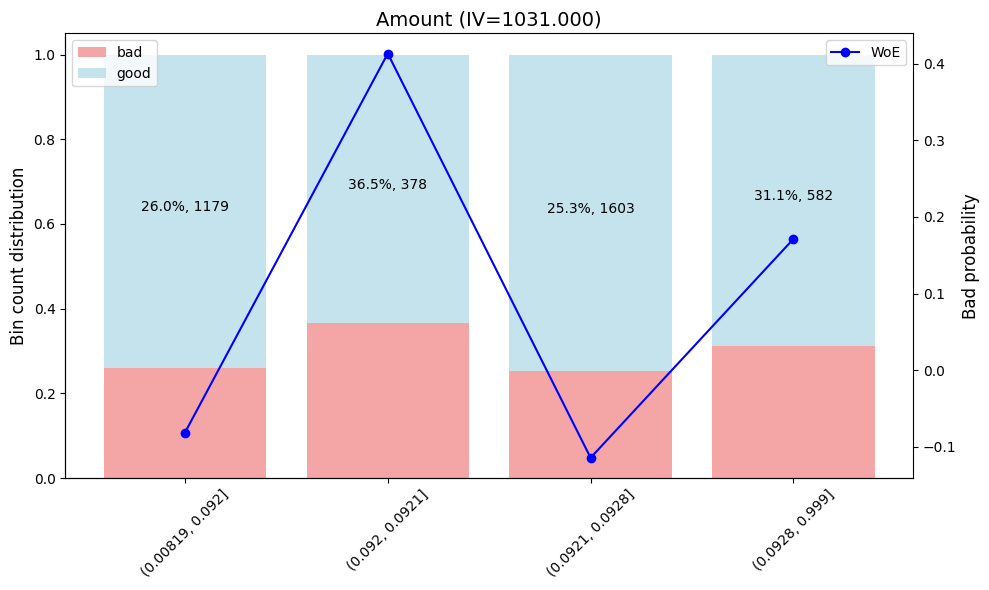

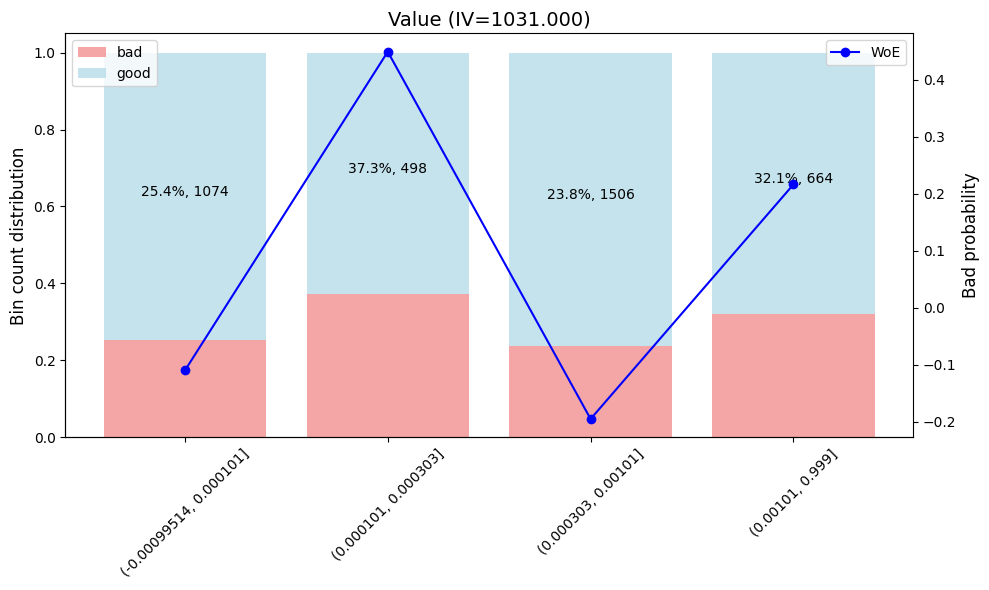

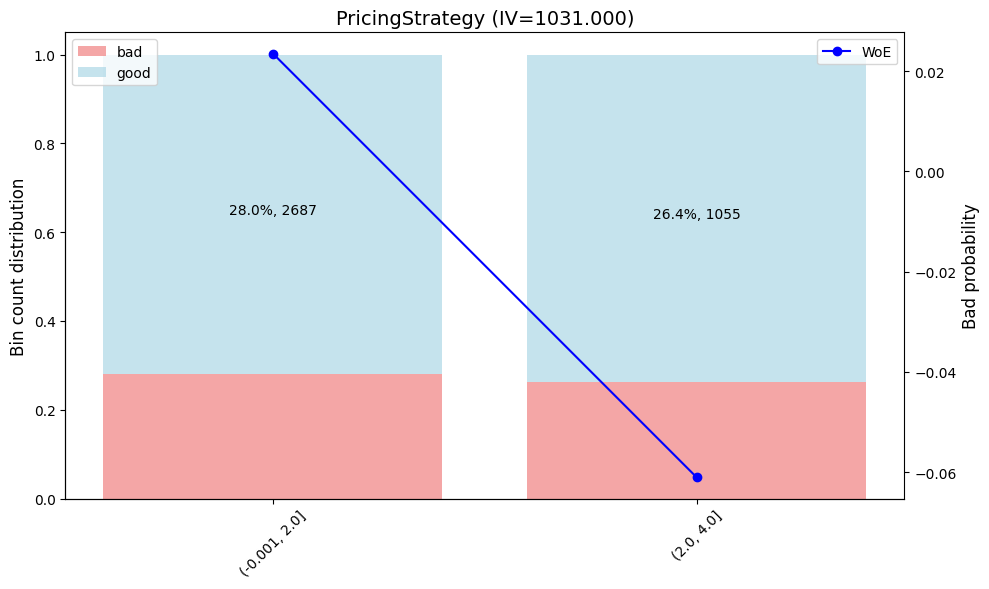

In [19]:
# Step 8: Plot WoE for a specific feature
feature_columns = merged_df[['Total_Transaction_Amount', 'Avg_Transaction_Amount',
       'Transaction_Count', 'Std_Transaction_Amount', 'Amount', 'Value',
       'PricingStrategy']]
# Replace 'NINQ' with your actual feature name and 'Risk_category' with your target variable
for feature in feature_columns:
    rfms_classifier.plot_woe_binned(merged_df, feature, 'Risk_category', bins=5)

### Dropping Features

In the process of preparing the dataset for the credit scoring model, the following features were identified and dropped for the reasons outlined below:

1. **Identifiers**: 
   - **`TransactionId`, `BatchId`, `AccountId`, `SubscriptionId`**: These columns serve as unique identifiers for transactions and accounts but do not provide any predictive value for the model.

2. **Non-Informative Features**: 
   - **`CurrencyCode`, `CountryCode`**: These features have unique values for each entry, making them non-informative for the modeling process.

3. **Redundant Metrics**: 
   - **`Amount`, `Value`, `Avg_Transaction_Amount`, `Total_Transaction_Amount`**: The `Total_Transaction_Amount` effectively captures the transaction value, rendering these columns redundant.

4. **Time-Based Features**: 
   - **`Transaction_Hour`, `Transaction_Day`, `Transaction_Month`, `Transaction_Year`**: These columns were dropped as they do not contribute unique information relevant to the credit scoring analysis.

5. **Transaction Timestamp**: 
   - **`TransactionStartTime`**: This feature was removed as it is not needed for the modeling process.

By dropping these features, the dataset is streamlined, improving model efficiency and interpretability while retaining `CustomerId` for merging purposes.


#### Merging Filtered Data and Cleaning Up Unnecessary Columns

#### Saving the Merged Data to CSV

In [32]:
# save merged data
file_path='../data'
rfms_classifier.save_merged_data(merged_df, output_file='final_merged_data', file_path=file_path)

Merged data saved to ../data/final_merged_data.csv


### RFMS Risk Classification with WoE Binning

This notebook implements an RFMS (Recency, Frequency, Monetary, Seasonality) model for customer risk classification and applies Weight of Evidence (WoE) binning to assess risk categories.

## Key Steps:

1. **Feature Calculation:**
   - **Recency**: Days since last transaction.
   - **Frequency**: Number of transactions per customer.
   - **Monetary**: Total transaction amount per customer.
   - **Seasonality**: Unique months of customer transactions.

2. **RFMS Normalization:**
   - Normalize RFMS features for consistency.

3. **Risk Classification:**
   - Calculate an RFMS score and classify customers as 'good' or 'bad' based on a threshold.

4. **WoE Binning & IV Calculation:**
   - Perform WoE binning for risk segmentation.
   - Calculate Information Value (IV) to evaluate feature predictive power.

5. **Data Export:**
   - Save the final classified dataset as a CSV.

### Conclusion:
The RFMS model, combined with WoE binning, provides a method to classify customers based on their transaction behavior and determine their risk level, aiding in better decision-making.
